In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
from pathlib import Path
import sys, os
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error


In [2]:
# Add the module path
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# Import custom modules
from src.utils.nyc_taxi_zones import TaxiZones
from src.utils.nyc_trip_loader import NYCTripData


Loading precomputed graph from C:\Users\0201u\Desktop\MSU\Graduate\2nd year\Fall Semester\CSE 881\Project\Git\demand-forecast\data\taxi_zones\precomputed_graphs\G_nyc_3ec450e2f75c938546192cae174c0cb4.graphml
Graph already exists at C:\Users\0201u\Desktop\MSU\Graduate\2nd year\Fall Semester\CSE 881\Project\Git\demand-forecast\data\taxi_zones\precomputed_graphs\G_nyc_3ec450e2f75c938546192cae174c0cb4.graphml. Did not overwrite.


In [3]:
# Set directories
BASE_DIR = Path.cwd().parent
DATA_DIR = BASE_DIR / 'data'
OUTPUT_DIR = BASE_DIR / 'output'


In [4]:
# Load the taxi trip data
val_data = NYCTripData('2021-09', '2022-08', dataset='fhvhv')
train_data = NYCTripData('2022-09', '2023-08', dataset='fhvhv')
test_data = NYCTripData('2023-09', '2024-08', dataset='fhvhv')


c:\Users\0201u\Desktop\MSU\Graduate\2nd year\Fall Semester\CSE 881\Project\Git\demand-forecast\src\utils\nyc_trip_loader.py:185: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weather_data.fillna(method='ffill', inplace=True)
c:\Users\0201u\Desktop\MSU\Graduate\2nd year\Fall Semester\CSE 881\Project\Git\demand-forecast\src\utils\nyc_trip_loader.py:185: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weather_data.fillna(method='ffill', inplace=True)
c:\Users\0201u\Desktop\MSU\Graduate\2nd year\Fall Semester\CSE 881\Project\Git\demand-forecast\src\utils\nyc_trip_loader.py:185: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weather_data.fillna(method='ffill', inplace=True)


In [5]:
# Load the preprocessed weather data
weather_data_encoded = pd.read_csv(DATA_DIR / 'open_weather_data_encoded.csv')


In [6]:
# Remove ' UTC' from the 'dt_iso' column
weather_data_encoded['dt_iso'] = weather_data_encoded['dt_iso'].str.replace(' UTC', '', regex=False)

# Convert 'dt_iso' to datetime in US/Eastern time zone
weather_data_encoded['dt_iso_ET'] = pd.to_datetime(
    weather_data_encoded['dt_iso'],
    utc=True
).dt.tz_convert('US/Eastern')

# Set 'dt_iso_ET' as the index
weather_data_encoded.set_index('dt_iso_ET', inplace=True)
weather_data_encoded.drop(columns=['dt_iso'], inplace=True)

# Resample the weather data to hourly intervals
weather_hourly_mean = weather_data_encoded.resample('H').mean()
one_hot_cols = [col for col in weather_data_encoded.columns if col.startswith('weather_desc_')]
weather_hourly_one_hot = weather_data_encoded[one_hot_cols].resample('H').max()
weather_hourly = pd.concat([weather_hourly_mean, weather_hourly_one_hot], axis=1)
weather_hourly.fillna(method='ffill', inplace=True) # Forward fill
weather_hourly.fillna(method='bfill', inplace=True)  # Backward fill, if any remain

C:\Users\0201u\AppData\Local\Temp\ipykernel_21412\2288994893.py:15: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  weather_hourly_mean = weather_data_encoded.resample('H').mean()
C:\Users\0201u\AppData\Local\Temp\ipykernel_21412\2288994893.py:17: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  weather_hourly_one_hot = weather_data_encoded[one_hot_cols].resample('H').max()
C:\Users\0201u\AppData\Local\Temp\ipykernel_21412\2288994893.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weather_hourly.fillna(method='ffill', inplace=True) # Forward fill
C:\Users\0201u\AppData\Local\Temp\ipykernel_21412\2288994893.py:20: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weather_hourly.fillna(method='bfill', inp

In [7]:
# Check for NaN values in weather_hourly
if weather_hourly.isnull().values.any():
    print("NaN values found in weather_hourly")
else:
    print("No NaN values in weather_hourly")


No NaN values in weather_hourly


In [8]:
# Define observation and forecast windows
obs_w = 24  # Observation window size
frcst_w = 1  # Forecast window size


In [9]:
# Function to create time index for trip data
def create_time_index(data, start_date_str):
    start_datetime = pd.to_datetime(start_date_str + '-01 00:00:00').tz_localize('US/Eastern')
    num_timesteps = data.trip_data.shape[1]
    time_index = pd.date_range(start=start_datetime, periods=num_timesteps, freq='H')
    return time_index

# Create time indices
time_index_train = create_time_index(train_data, '2022-09')
time_index_val = create_time_index(val_data, '2021-09')
time_index_test = create_time_index(test_data, '2023-09')


C:\Users\0201u\AppData\Local\Temp\ipykernel_21412\729364044.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_index = pd.date_range(start=start_datetime, periods=num_timesteps, freq='H')


In [10]:
# Feature extraction functions
def extract_features_and_target_no_weather(data, obs_w, frcst_w):
    X_list = []
    y_list = []

    num_nodes = data.trip_data.shape[0]
    num_timesteps = data.trip_data.shape[1]

    for i in range(0, num_timesteps - obs_w - frcst_w + 1):
        for node in range(num_nodes):
            # Extract observed window features (PU_count is at index -1)
            obs_window = data.trip_data[node, i:i + obs_w, -1].astype(float)
            # Combine features (only using historical PU_counts)
            X_sample = obs_window.flatten()
            # Extract target variable (PU_count at time i + obs_w)
            y_sample = float(data.trip_data[node, i + obs_w, -1])
            X_list.append(X_sample)
            y_list.append(y_sample)
    X = np.array(X_list)
    y = np.array(y_list)
    return X, y



In [11]:
def extract_features_and_target_with_weather(data, obs_w, frcst_w, weather_data, time_index):
    X_list = []
    y_list = []

    num_nodes = data.trip_data.shape[0]
    num_timesteps = data.trip_data.shape[1]

    expected_length = None  # To store the expected length of X_sample

    for i in range(0, num_timesteps - obs_w - frcst_w + 1):
        current_time = time_index[i + obs_w]
        # Get weather data at current_time
        if current_time in weather_data.index:
            weather_features = weather_data.loc[current_time].values
        else:
            # If weather data is missing, skip this sample
            continue
        for node in range(num_nodes):
            # Extract observed window features (PU_count is at index -1)
            obs_window = data.trip_data[node, i:i + obs_w, -1].astype(float)
            # Combine features (historical PU_counts and weather features)
            X_sample = np.concatenate([obs_window.flatten(), weather_features])
            # Check the length of X_sample
            if expected_length is None:
                expected_length = len(X_sample)
            elif len(X_sample) != expected_length:
                print(f"Inconsistent feature vector length at time {current_time} and node {node}.")
                print(f"Expected length: {expected_length}, Actual length: {len(X_sample)}")
                continue  # Skip this sample or handle it accordingly
            # Extract target variable (PU_count at time i + obs_w)
            y_sample = float(data.trip_data[node, i + obs_w, -1])
            X_list.append(X_sample)
            y_list.append(y_sample)
    X = np.array(X_list, dtype=np.float32)
    y = np.array(y_list, dtype=np.float32)
    return X, y


In [12]:
# Prepare data without weather
# Training data
X_train_no_weather, y_train_no_weather = extract_features_and_target_no_weather(train_data, obs_w, frcst_w)
scaler_no_weather = StandardScaler()
X_train_no_weather_scaled = scaler_no_weather.fit_transform(X_train_no_weather)

# Validation data
X_val_no_weather, y_val_no_weather = extract_features_and_target_no_weather(val_data, obs_w, frcst_w)
X_val_no_weather_scaled = scaler_no_weather.transform(X_val_no_weather)

# Test data
X_test_no_weather, y_test_no_weather = extract_features_and_target_no_weather(test_data, obs_w, frcst_w)
X_test_no_weather_scaled = scaler_no_weather.transform(X_test_no_weather)


In [13]:
# Prepare data with weather
# Training data
X_train_with_weather, y_train_with_weather = extract_features_and_target_with_weather(train_data, obs_w, frcst_w, weather_hourly, time_index_train)
scaler_with_weather = StandardScaler()
X_train_with_weather_scaled = scaler_with_weather.fit_transform(X_train_with_weather)

# Validation data
X_val_with_weather, y_val_with_weather = extract_features_and_target_with_weather(val_data, obs_w, frcst_w, weather_hourly, time_index_val)
X_val_with_weather_scaled = scaler_with_weather.transform(X_val_with_weather)

# Test data
X_test_with_weather, y_test_with_weather = extract_features_and_target_with_weather(test_data, obs_w, frcst_w, weather_hourly, time_index_test)
X_test_with_weather_scaled = scaler_with_weather.transform(X_test_with_weather)


In [14]:
# Train and evaluate model without weather data
model_no_weather = LinearRegression()
model_no_weather.fit(X_train_no_weather_scaled, y_train_no_weather)

# Predict and evaluate on validation data
y_pred_val_no_weather = model_no_weather.predict(X_val_no_weather_scaled)
mse_val_no_weather = mean_squared_error(y_val_no_weather, y_pred_val_no_weather)
print(f"Validation MSE without weather data: {mse_val_no_weather:.4f}")

# Predict and evaluate on test data
y_pred_test_no_weather = model_no_weather.predict(X_test_no_weather_scaled)
mse_test_no_weather = mean_squared_error(y_test_no_weather, y_pred_test_no_weather)
print(f"Test MSE without weather data: {mse_test_no_weather:.4f}")


Validation MSE without weather data: 627.8013
Test MSE without weather data: 875.1769


In [15]:
# Train and evaluate model with weather data
model_with_weather = LinearRegression()
model_with_weather.fit(X_train_with_weather_scaled, y_train_with_weather)

# Predict and evaluate on validation data
y_pred_val_with_weather = model_with_weather.predict(X_val_with_weather_scaled)
mse_val_with_weather = mean_squared_error(y_val_with_weather, y_pred_val_with_weather)
print(f"Validation MSE with weather data: {mse_val_with_weather:.4f}")

# Predict and evaluate on test data
y_pred_test_with_weather = model_with_weather.predict(X_test_with_weather_scaled)
mse_test_with_weather = mean_squared_error(y_test_with_weather, y_pred_test_with_weather)
print(f"Test MSE with weather data: {mse_test_with_weather:.4f}")


Validation MSE with weather data: 819.3750
Test MSE with weather data: 865.7104


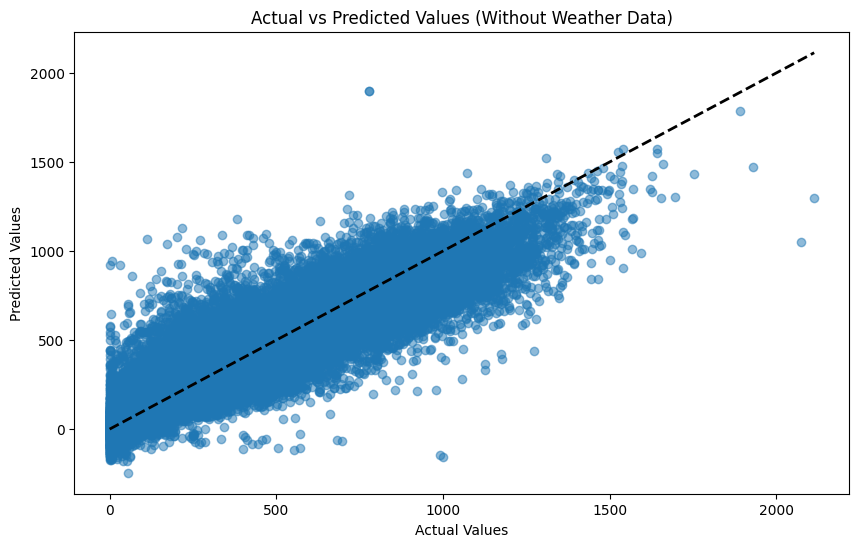

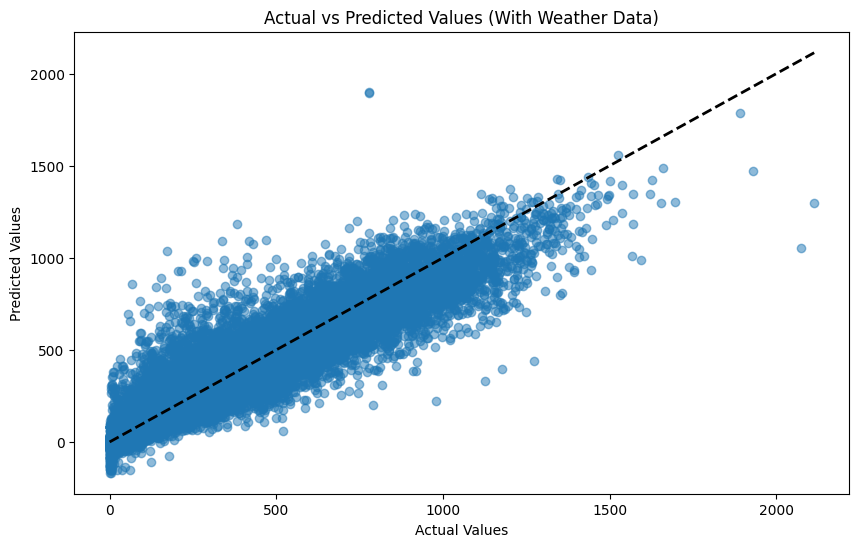

In [16]:
# Plotting the results
# For test data without weather
plt.figure(figsize=(10,6))
plt.scatter(y_test_no_weather, y_pred_test_no_weather, alpha=0.5)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values (Without Weather Data)')
plt.plot([y_test_no_weather.min(), y_test_no_weather.max()], [y_test_no_weather.min(), y_test_no_weather.max()], 'k--', lw=2)
plt.show()

# For test data with weather
plt.figure(figsize=(10,6))
plt.scatter(y_test_with_weather, y_pred_test_with_weather, alpha=0.5)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values (With Weather Data)')
plt.plot([y_test_with_weather.min(), y_test_with_weather.max()], [y_test_with_weather.min(), y_test_with_weather.max()], 'k--', lw=2)
plt.show()

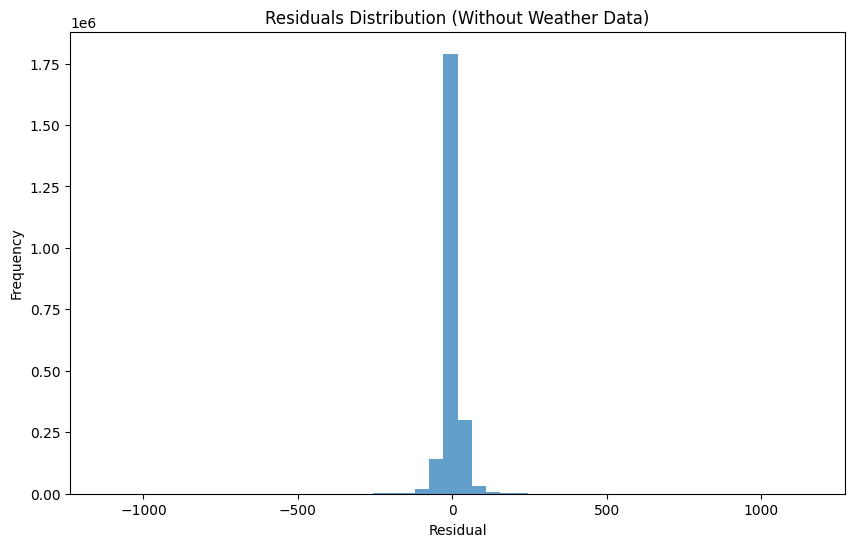

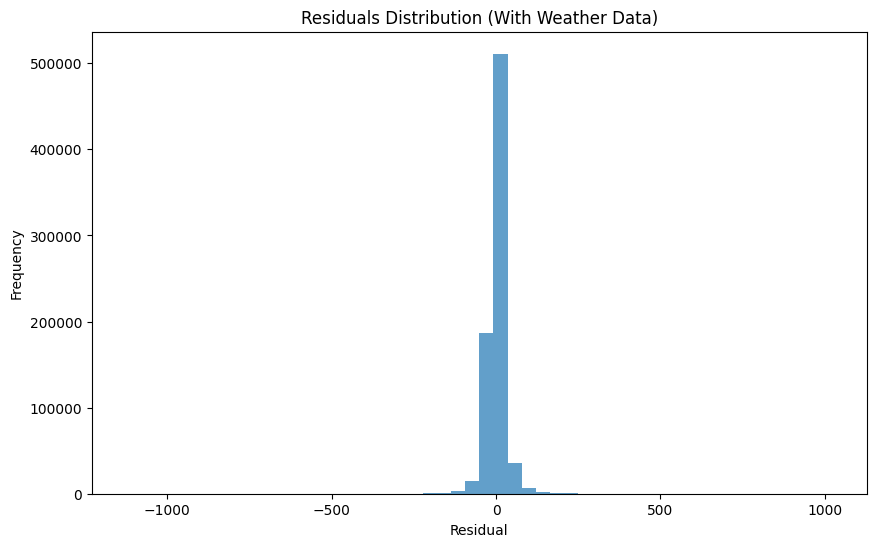

In [17]:
# Plotting residuals
# Residuals without weather data
residuals_no_weather = y_test_no_weather - y_pred_test_no_weather
plt.figure(figsize=(10,6))
plt.hist(residuals_no_weather, bins=50, alpha=0.7)
plt.title('Residuals Distribution (Without Weather Data)')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.show()

# Residuals with weather data
residuals_with_weather = y_test_with_weather - y_pred_test_with_weather
plt.figure(figsize=(10,6))
plt.hist(residuals_with_weather, bins=50, alpha=0.7)
plt.title('Residuals Distribution (With Weather Data)')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.show()

----------